<font size=5  color=#003366> <b>[LELEC2900] - Signal Processing <br><br> 
Python07 - Image Inpainting</b> </font> <br><br><br>

<font size=5  color=#003366>
Prof. L. Vandendorpe<br>
Prof. L. Jacques
<br><br>
Anne-Sophie Collin (anne-sophie.collin@uclouvain.be)<br> 
Florian Quatresooz (florian.quatresooz@uclouvain.be) <br>
<br><br>
</font>

<font size=5 color=#009999> <b> PART I - Introduction </b> </font> <br> 

In signal processing, inpainting is the process of reconstituting images or videos in which some pixels are missing or damaged. This open problem has been subject to a lot of interest in the literature (it is actually part of a general research field called 'Inverse problems'). Given one damaged image, many different algorithms exist to reconstruct it. These algorithms can rely on different mathematical techniques (differential equations, machine learning,...). In the framework of this session, we will mainly focus on algorithms that have been presented during the lecture about compressive sensing.

The code to write in this notebook is quite short (about 20 lines). The objective of this session is rather to understand the mathematical concepts and operations that are introduced.

<br>

<font size=5 color=#009999> <i>1.1  Mathematical formulation of the problem</i>  </font> <br> 


In this notebook, we consider a damaged image $y$ with missing pixels, defined as

$$y=\Phi f_0 + w$$

In this equation:
- $f_0$ is the original pure image (with no missing pixels) 
- $\Phi$ is a masking operator (removing pixels at random locations)
- $w$ is an additive noise.

It is assumed that the image is sparse when it is decomposed in a certain set of basis functions (this kind of set is called *frame* in the literature). In other words, if we decompose $f_0$ as the weighted sum of basis functions $\psi_m$, many of the weighting coefficients $a_m$ of the sum  will be equal to zero. In this notebook, we will use as basis functions the wavelets studied in the previous chapter.

The objective of the algorithms that will be implememented in this session is to compute an optimal estimate $f^{\star}$ of $f_0$ based on the available information $y$. They will hence produce the final estimate $f^{\star}$ or the associated coefficients $ (a_m^{\star})_m $ in the frame $(\psi_m)_m$.

The objective of these algorithms is to solve the following optimization problem:

$$a^{\star} \in \text{argmin}_a \: \frac{1}{2}\|y-\Phi \Psi a\|^2 \; \; \text{such that} \; \;  \sum_m \|a_m\| < K \; \; \; (\text{Formulation} \; 1) $$

where $K$ is some constant and where the notation $\Psi a \triangleq \sum_m a_m \psi_m$ denotes the reconstruction operator.

In short, this objective function means that we are looking for an image $\Psi a$ : 

- whose associated set of coefficients is sparse (by the constraint $\sum_m \|a_m\| < K$) 
- which is the closest possible to the damaged image $y$ when we apply the mask on it (by minimizing $\|y-\Phi \Psi a\|^2$)


The above problem can be slightly modified and reformulated by means of sparsity regularization (in other words, the constraint is removed and replaced by a second term in the objective function).

$$a^{\star} \in \text{argmin}_a \: \frac{1}{2}\|y-\Phi \Psi a\|^2 + \lambda \sum_m \|a_m\| \; \; \; (\text{Formulation} \; 2)$$

where $\lambda$ should be adapted according to the noise level $\|w\|$.
In this notebook we consider damaged observation without noise, i.e.
$w=0$. As a consequence we use a very small value of $\lambda$ , or we decay its
value through the iterations of the recovery process.

<br>

<font size=5 color=#009999> <i>1.2  Organization</i>  </font> <br> 

This session will be structured as follows : 

- In part I, you will download one given image and remove some of its pixels by means of a random mask
- In part II, you will implement a first inpainting algorithm using iterative soft thresholding
- In part III, you will implement a second inpainting algorithm using iterative hard thresholding.

Before starting the exercise, you are ask to download the folder nt_toolbox.zip available on Moodle. Unzip it and move the files nt_toolbox.general and nt_toolbox.signal to your working directory. These files contain functions that you will use. 

In [1]:
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
from nt_toolbox.perform_wavelet_transf import *

import numpy as np
from numpy import random
from numpy import linalg

import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<br>

<font size=5 color=#009999> <b> PART II -  Masking the image </b> </font> <br> 
<br>

In this first part, nothing has to be implemented. You just have to run and to try to understand each section. 

First we load the image to be inpainted.

In [2]:
n  = 128
f0 = load_image("nt_toolbox/data/lena.png")
f0 = rescale(f0[256-n//2:256+n//2,256-n//2:256+n//2])

Display it.

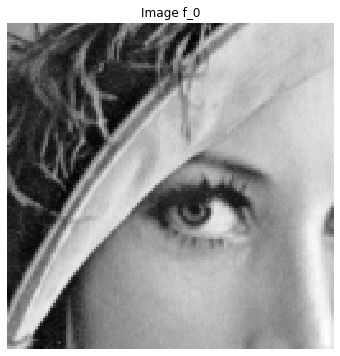

In [3]:
plt.figure(figsize = (6,6))
imageplot(f0, 'Image f_0')
plt.show()

Amount of removed pixels.

In [4]:
rho = .7

Then we construct a mask $\Omega$ made of random pixel locations.

In [5]:
Omega = np.zeros([n, n])
sel   = random.permutation(n**2)
np.ravel(Omega)[sel[np.arange(int(rho*n**2))]] = 1

The damaging operator put to zeros the pixel locations $x$ for which $\Omega(x)=1$

In [6]:
Phi = lambda f, Omega: f*(1-Omega)

The damaged observations reads $y = \Phi f_0$.

In [7]:
y = Phi(f0, Omega)

Display the observations.

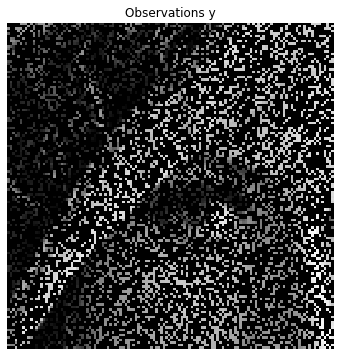

In [8]:
plt.figure(figsize = (6,6))
imageplot(y, 'Observations y')

<br>

<font size=5 color=#009999> <b> PART III -  Inpainting using soft thesholding </b> </font> <br> 
<br>

Let us first (re)introduce the concept of wavelet transform and soft thresholding which are going to be useful here.

<br>

<font size=5 color=#009999> <i>3.1  Wavelet transform </i>  </font> <br> 

In this notebook, the wavelet transform will be performed by using function  <samp>perform_wavelet_transf</samp> that has been downloaded from Moodle. 

This function takes the following arguments as input: 

- The element on which the transform has to be applied (either the image or the coefficients of the basis functions)
- Jmin, the minimum number of decomposition levels that the function will reach. Efficient values for this parameter are provided here below (how they are obtained is beyond the scope of this course).
- dir, that has to be set to 1 if the transform is performed from image to the coefficients or -1 if the transform is applied from coefficients to image.
- ti, indicating whether the wavelet transform has to be translation invariant. It can be set to 1 here.

In [9]:
Jmax = np.log2(n)-1
Jmin = (Jmax-3)

Let $\Psi^{*}$ be the wavelet transform operator that is applied on the image to produce the wavelet coefficients, and let $\Psi$ be the reconstruction operator (performing the inverse operation).

**Exercise 1** - Using perform_wavelet_transf, define two shortcut functions for $\Psi^{*}$ and $\Psi$.

In [10]:
from nt_toolbox.perform_wavelet_transf import *

# Complete here.

def phi_s(x):
    y = perform_wavelet_transf(x, Jmin, 1, ti = 1)
    return y

def phi(y):
    x = perform_wavelet_transf(y, Jmin, -1, ti = 1)
    return x


<br>

<font size=5 color=#009999> <i>3.2  Soft thresholding </i>  </font> <br> 

The soft thresholding operator is at the heart of $\ell^1$ minimization schemes. 

The soft thresholding is a 1-D functional that shrinks the value of
coefficients $u$:

$$ s_T(u)=\max \left( 0,1-\frac{T}{|u|} \right)u $$
 
where $T$ is the chosen threshold.

**Exercise 2** - Define a function for this soft thresholding 1-D functional. This function should be able to handle any size of input $u$ (you can hence use function np.shape). Display the curve of this function in 1D for $T=0.5$.

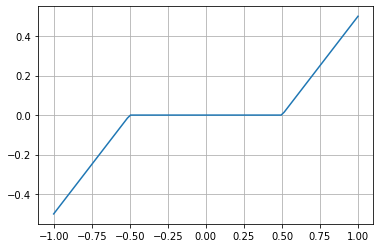

In [11]:
def st(u,T):
    
    
    def handle_dim(u,T):
        nu = []
        if u.ndim == 1:
            for coef in u:
                nu.append(max(0,1-T/coef)*coef)
        else:
            for l in u:
                nu.append(handle_dim(l,T))
        return nu

    return np.array(handle_dim(u,T))

def st(u,T):
    shape = np.shape(u)
    u = np.ravel(u)
    result =  np.maximum(np.zeros(len(u)),1-T/np.abs(u))*u
    return result.reshape(shape)



x = np.linspace(-1,1,100)
plt.plot(x,st(x,0.5))
plt.grid()
plt.show()


In the framework of this session, the soft thresholding operation will be applied on the wavelet coefficients of the image only. Given one image $f$, it is hence necessary to first computed its coefficients, then to soft threshold them, and then to reconstruct the image: 

$$ S_T^\Psi(f) = \Psi \circ S_T \circ \Psi^*$$

**Exercise 3** - Define a function SoftThreshPsi that implements the successive operations described in the equation here above.

In [12]:
def SoftThreshPsi(f,T):
    y = phi_s(f)
    s = st(y,T)
    x = phi(s)
    return x

<br>

<font size=5 color=#009999> <i>3.3 Description of the algorithm</i>  </font> <br> 


If $\Psi$ is an orthogonal basis, a change of variable shows that
formulation 2 can be rewritten as
$$f^{\star} \in \text{argmin}_f \: E(f) = \frac{1}{2}\|y-\Phi f\|^2 + \lambda \sum_m \|\langle f,\psi_m \rangle\|\; \; \; (\text{Formulation} \; 3) $$

This optimization problem can be solved by iteratively applying the two following steps: 

1. Using a gradient descent step to minimize the cost function: 

$$ \text{Proj}_C(f) = f - \tau \Phi^{*} (\Phi f - y) $$

where the step size $\tau$ can here be set to 1.

For sake of simplicity, it is possible to show that the following shortcut can be defined for this operation by using the mask $\Omega$: 

In [13]:
ProjC = lambda f, Omega: Omega*f + (1-Omega)*y

2. Soft thresholding the obtained result to promote sparsity with $\lambda$ as threshold parameter. Let's set up the value of this threshold: 

In [14]:
lambd = .03

Each iteration of the iterative thresholding algorithm
thus reads:
$$ f^{(\ell+1)} = S_{\lambda}^\Psi( \text{Proj}_C(f^{(\ell)}) ). $$

**Exercise 4** - Implement the iterative thresholding algorithm. Display the resulting image after 500 iterations. 
Display a graph depicting the evolution of the energy in Formulation 3 as function of the iterations. Evaluate the process by computing the SNR bettween the origninal image and its reconstruction.

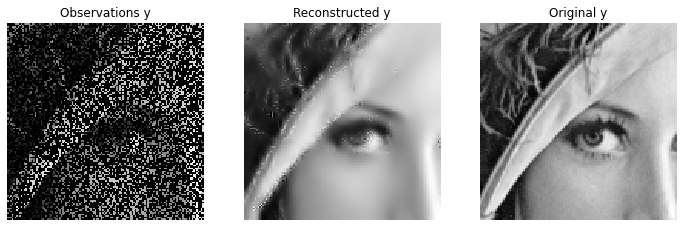

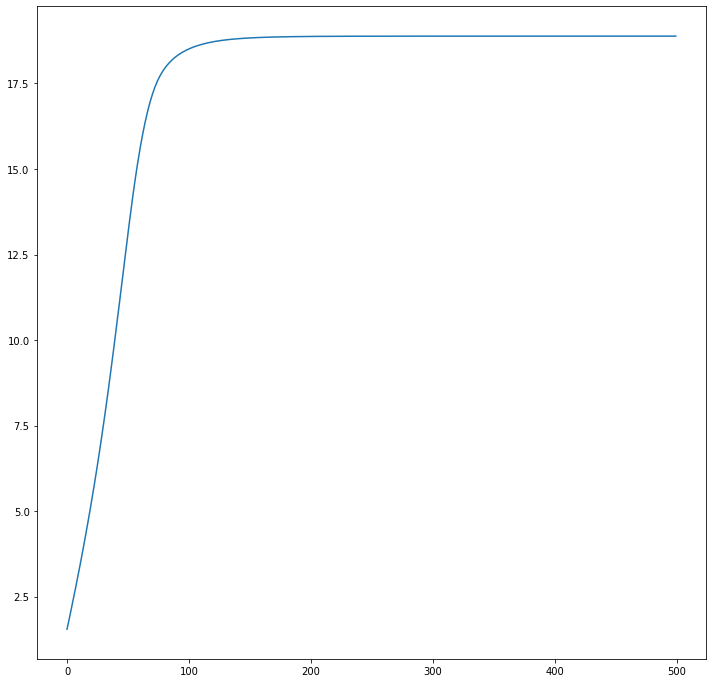

In [15]:
import tqdm
import copy

K = 500

r_y = copy.deepcopy(y)

energ=[]
snr_l=[]

def snr(x,x_o):
    sum1 = np.sum(x_o**2)
    sum2 = np.sum((x-x_o)**2)
    return 10*np.log10(sum1/sum2)


for k in tqdm.tqdm(range(K),leave=False):
    snr_l.append(snr(r_y,f0))
    r_y = SoftThreshPsi(ProjC(r_y,Omega),lambd)
    
    
plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
imageplot(y, 'Observations y')
plt.subplot(1,3,2)
imageplot(r_y, 'Reconstructed y')
plt.subplot(1,3,3)
imageplot(f0, 'Original y')

plt.figure(figsize = (12,12))
plt.plot(snr_l)


<br>

<font size=5 color=#009999> <b> PART IV -  Inpainting using hard thesholding </b> </font> <br> 
<br>

To improve the sparsity of the solution, it is possible to replace the
soft thresholding by a hard threshdoling.

The hard thresholding is defined as $h_T(x)=0$ if $-T < x < T$ for some threshold $T$
and $h_T(x)=x$ otherwise. 

**Exercise 5** - As for exercise 1, define a shortcut for this vectorialized hard thresholding operation. Display the curve of this function in 1D for $T = 0.5$

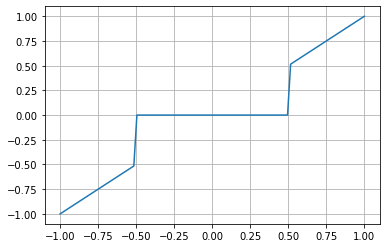

In [22]:
T = 0.5
def ht(u,T):
    shape = np.shape(u)
    h = u.copy()
    h[abs(h)<T] = 0
    return h

x = np.linspace(-1,1,100)

plt.figure()
plt.plot(x,ht(x,T))
plt.grid()
plt.show()

You can now apply the same algorithm as in part II in which you can replace the soft by the hard thresholding. 
In order to have proper results, you should use a decaying value of the threshold parameter ($\lambda$). Monotonically decreasing values ranging from 1 to 0 are a good setting. 

**Exercise 6** - Implement the iterative hard thresholding algorithm. Display the resulting image after 500 iterations. Evaluate this new method thank to the SNR of the reconstruction.

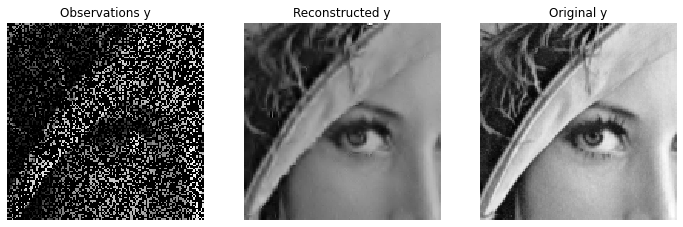

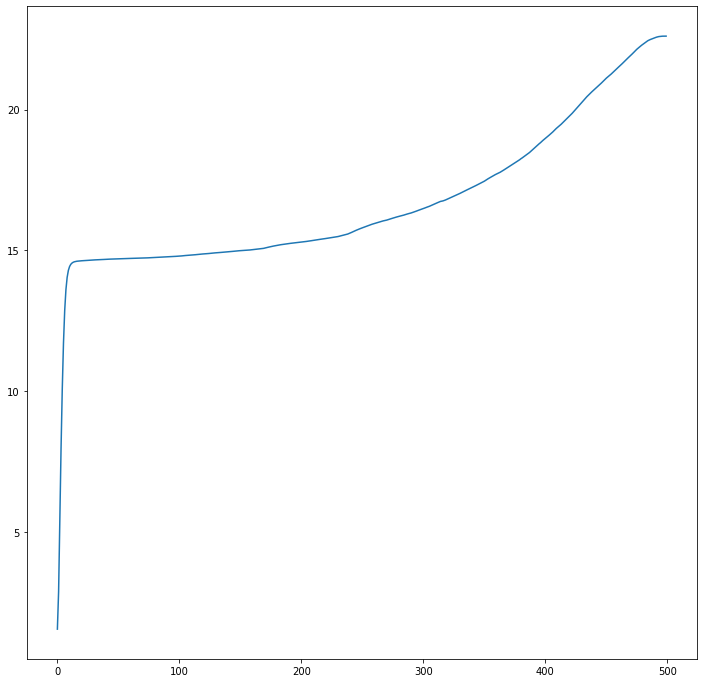

In [23]:
K = 500

r_hy = copy.deepcopy(y)

energ=[]
snr_hl=[]

def HardThreshPsi(f,T):
    y = phi_s(f)
    s = ht(y,T)
    x = phi(s)
    return x



th_p = np.flip(np.linspace(0,1,K))

for k in tqdm.tqdm(range(K),leave=False):

    snr_hl.append(snr(r_hy,f0))
    r_hy = HardThreshPsi(ProjC(r_hy,Omega),th_p[k])
    
    
plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
imageplot(y, 'Observations y')
plt.subplot(1,3,2)
imageplot(r_hy, 'Reconstructed y')
plt.subplot(1,3,3)
imageplot(f0, 'Original y')

plt.figure(figsize = (12,12))
plt.plot(snr_hl)


<br>

<font size=5 color=#009999> <b> Conclusion of the performances </b> </font> <br> 
<br>

**Image comparison** - Summary of the calculated image

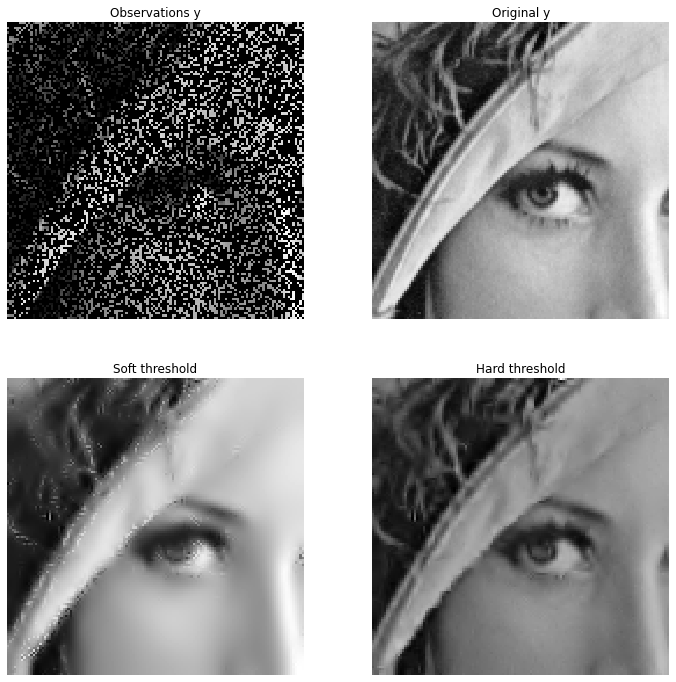

In [25]:
plt.figure(figsize = (12,12))
plt.subplot(2,2,1)
imageplot(y, 'Observations y')
plt.subplot(2,2,3)
imageplot(r_y, 'Soft threshold')
plt.subplot(2,2,4)
imageplot(r_hy, 'Hard threshold')
plt.subplot(2,2,2)
imageplot(f0, 'Original y')

**SNR Comparison over iteration**

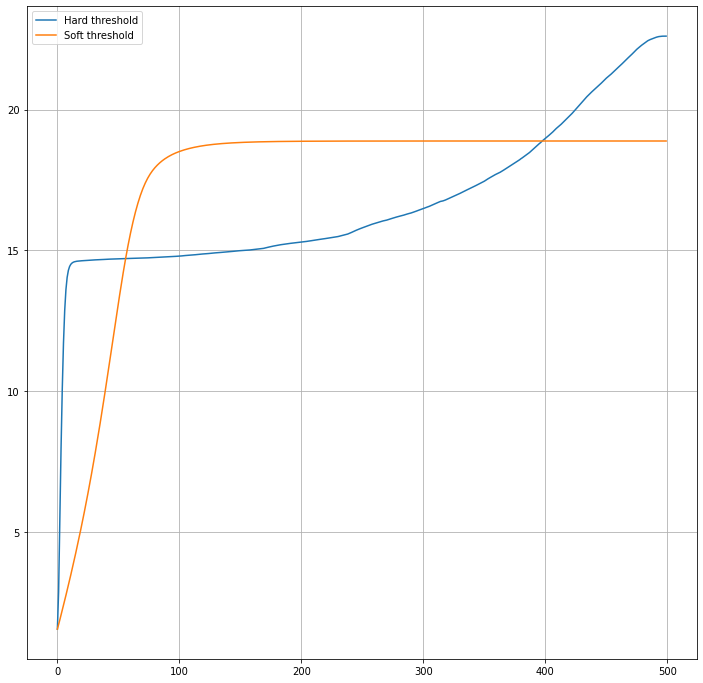

In [26]:
plt.figure(figsize = (12,12))
plt.plot(snr_hl,label="Hard threshold")
plt.plot(snr_l,label="Soft threshold")
plt.grid()
plt.legend()